### Feature Engineering

In [1]:
from ImgPrep import file_names, read_img, reshape_array, split_img, remove_background, fix_edges, flatten_arrays, glcmm
from ImgCluster import cluster_pixels, cluster_pieces, silhouette_analysis, optimalK
from Funcs4Testing import display_cluster_imgs, display_img, img_scatter, plot_silhouette_analysis, plot_gap_stats
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
import cdlib
from networkx.convert import to_networkx_graph as ToGraph
import joblib
import numpy as np
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# list of files to read in
files = file_names('puzzle_scans/puzzle_1')
pictures = [] # picture arrays
bgremoved = [] # pic arrays with scanner background removed
avg_rgb_pieces = [] # avg rgp of the entire puzzle piece
pic_arrays = [] # flattened pic arrays
pic_arrays_filtered = [] # flattened pic arrays w/ [0,0,0] pixels filtered out
features = []

for i in range(1, len(files) + 1):
    
    # store picture as array
    pic = read_img(files, i)

    # split each image into 20 pieces
    pieces = split_img(pic, 5, 4)
    pictures += pieces
    assert all([piece.shape for piece in pieces]), 'All arrays are not the same size'

shape = pieces[0].shape

# remove scanner background from images and reshape arrays for clustering
# for indx,img in enumerate(pictures):
    
#     # remove background
#     pic_bgremoved = remove_background(img)
#     pic_bgremoved = fix_edges(pic_bgremoved, indx, shape)
#     assert pic_bgremoved.shape == img.shape, \
#         'Picture with background removed is not the same size as original picture'
#     bgremoved.append(pic_bgremoved)
    
#     # flatten picture array
#     flat_pic = reshape_array(pic_bgremoved, starting_dim = len(pic_bgremoved.shape))
#     assert flat_pic.shape[0] == img.shape[0] * img.shape[1], \
#         'Flattened picture does not have the same number of pixels as original picture'
#     pic_arrays.append(flat_pic)
    
#     # find average rgb of entire piece
#     keep_indices = np.where(np.sum(flat_pic, axis = 1) > 0)[0]
#     flat_pic_filtered = flat_pic[keep_indices]
#     pic_arrays_filtered.append(flat_pic_filtered)
#     avg_rgb_pieces.append(np.mean(flat_pic_filtered, axis = 0))

# assert len(bgremoved) == len(pictures), \
#     'List of pictures with background removed is not the same size as original list of pictures'
# assert len(pic_arrays_filtered) == len(pictures), \
#     'List of flattened picture arrays is not the same size as original list of pictures'
# assert len(avg_rgb_pieces) == len(pictures), \
#     'Quantity of average rgb values % quantity of puzzle pieces' % ('exceeds' if len(avg_rgb_pieces) > len(pictures) else 'is less than')

# # Find RGB values of cluster centers for each puzzle piece
# clustered_pixels = cluster_pixels(pixels = pic_arrays_filtered, n_clusters = 3)
# # joblib.dump(clustered_pixels_pixels, 'pickle_files/clustered_pixels.pkl')

# # flatten cluster centers to use in features
# centers_flattened = flatten_array(clustered_pixels)
# # joblib.dump(centers_flattened, 'pickle_files/centers_flattened.pkl')

avg_rgb_pieces = joblib.load('pickle_files/avg_rgb_pieces.pkl')
bgremoved = joblib.load('pickle_files/bgremoved.pkl')
centers_flattened = joblib.load('pickle_files/centers_flattened')

# find texture features   
txtr_features = np.empty((len(bgremoved),24))
for indx,img in enumerate(bgremoved):
    txtr_features[indx] = glcmm(img)
    
# concatenate all features for clustering pieces
feature_set =  np.concatenate((avg_rgb_pieces, centers_flattened, txtr_features), axis = 1)


Bad key "text.kerning_factor" on line 4 in
/Users/jstaley/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Clustering

Optimal k is: 9


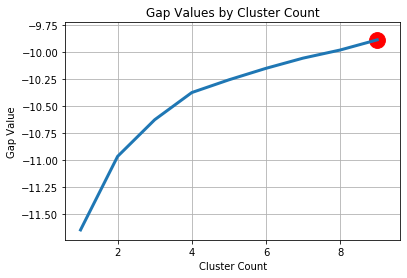

In [2]:
# perform silhouette analysis to determine optimal k for clustering
# range_n_clusters = np.arange(2,11)

# for n_clusters in range_n_clusters:
#     sample_silhouette_values, cluster_labels = silhouette_analysis(feature_set, n_clusters)
#     plot_silhouette_analysis(feature_set, sample_silhouette_values, cluster_labels, n_clusters)

# calculate gap-statistic to determine optimal k for clustering
k, gapdf = optimalK(feature_set, maxClusters = 10)
print(f'Optimal k is: {k}')

plot_gap_stats(gapdf, k)

In [3]:


# perform Isomap clustering on final feature set
iso_model = Isomap(n_components = 2).fit_transform(feature_set)

# perform k-means clustering
km = KMeans(n_clusters = k).fit(feature_set)

### Goodness of Fit
[Evaluation metrics provided by 'cdlib' package](https://cdlib.readthedocs.io/en/latest/reference/classes/node_clustering.html#methods)

In [4]:
# compare clusters to adjacency graph
adj = np.loadtxt('AdjacencyMatrices/Puzzle1_AdjacencyMatrix.csv', delimiter = ',', dtype=int)
assert adj.shape[0] == adj.shape[1], 'Adjacency matrix must be symmetrical'
assert adj.shape[0] == len(pictures), 'Adjacency matrix should have one row and one column for every puzzle piece'

# Convert the adjacency matrix into a NetworkX graph object
adjG = ToGraph(adj)

# store indices of each cluster in list of lists
clusters = []
for i in range(k):
    i_indices = np.where(km.labels_ == i)[0].tolist()
    clusters.append(i_indices)

# Use the clusters and the adjacency matrix graph to create cdlib 'NodeClustering' object
Comms = cdlib.NodeClustering(clusters, adjG, 'Manual')

# Using the object created above, many 'fittness' metrics can be calculated
cdlib.evaluation.erdos_renyi_modularity(adjG,Comms)

FitnessResult(min=None, max=None, score=0.0820249050939588, std=None)

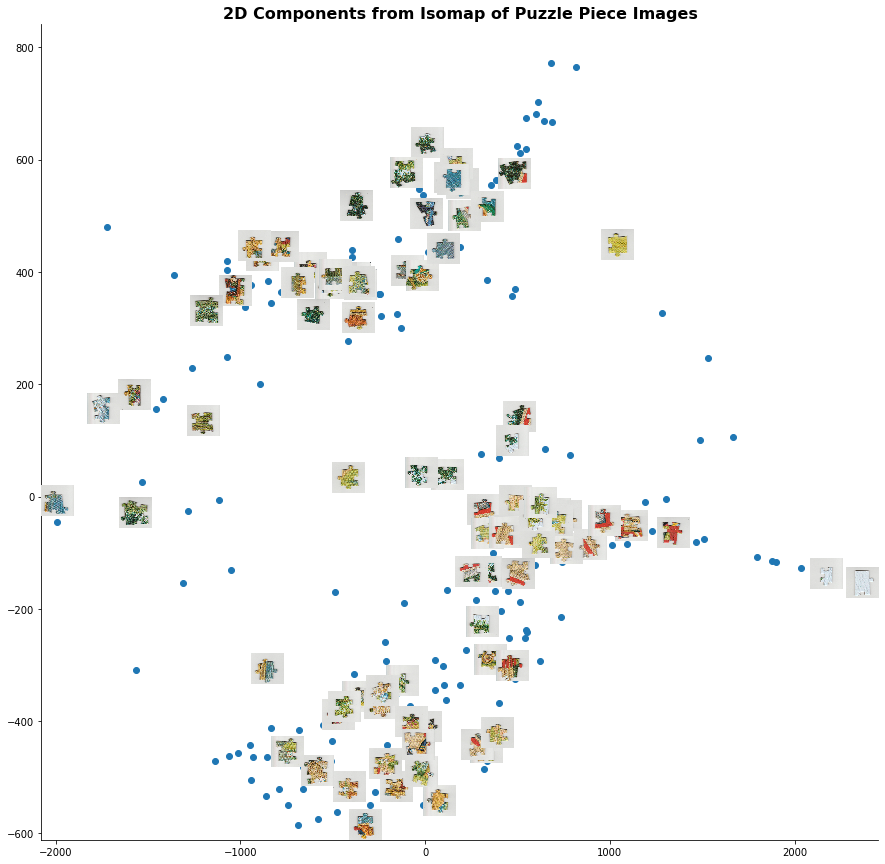


Images in cluster 4:



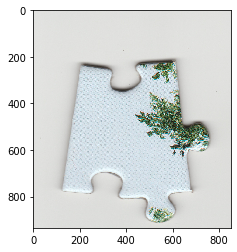

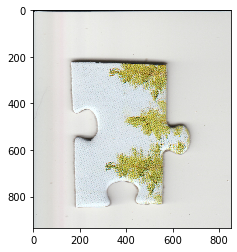

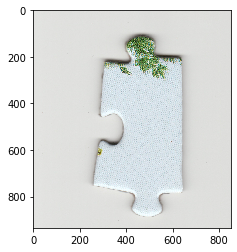

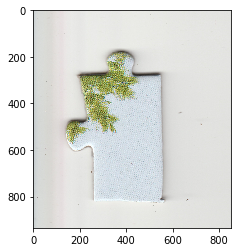

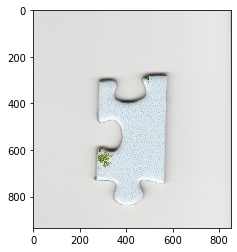

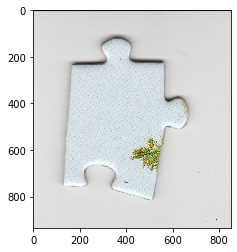

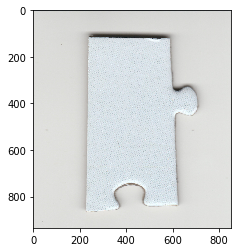

In [6]:
# visual check of isomap clusters
img_scatter(iso_model, pictures, 100)

# visual inspection of KMeans clusters
display_cluster_imgs(pictures, km.labels_, 4)